In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
from astropy.io import fits

import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import emcee

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph, center_deemph

In [2]:
cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)

### PW1-00

In [28]:
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from spectres import spectres

def get_spec(filename, rebin=None):
    hdu = fits.open(filename)[0]

    hdr = hdu.header
    data = hdu.data
    
    # flux = data[2]
    # err = data[3]
    flux = data[0]
    err = data[1]
    wvln = 10 ** (hdr['CRVAL1'] + hdr['CDELT1']*np.arange(hdr['NAXIS1']))
    
    kw = dict()
    if rebin:
        flux, err = spectres(wvln[10:-10:rebin], 
                             wvln, flux, err)
        wvln = wvln[10:-10:rebin]
    kw['spectral_axis'] = wvln * u.angstrom

    return Spectrum1D(flux=flux * u.one,
                      uncertainty=StdDevUncertainty(err*u.one),
                      **kw)

In [29]:
spec = get_spec('../data/pw1-00_comb_multi_stitchbr.fits', rebin=4)

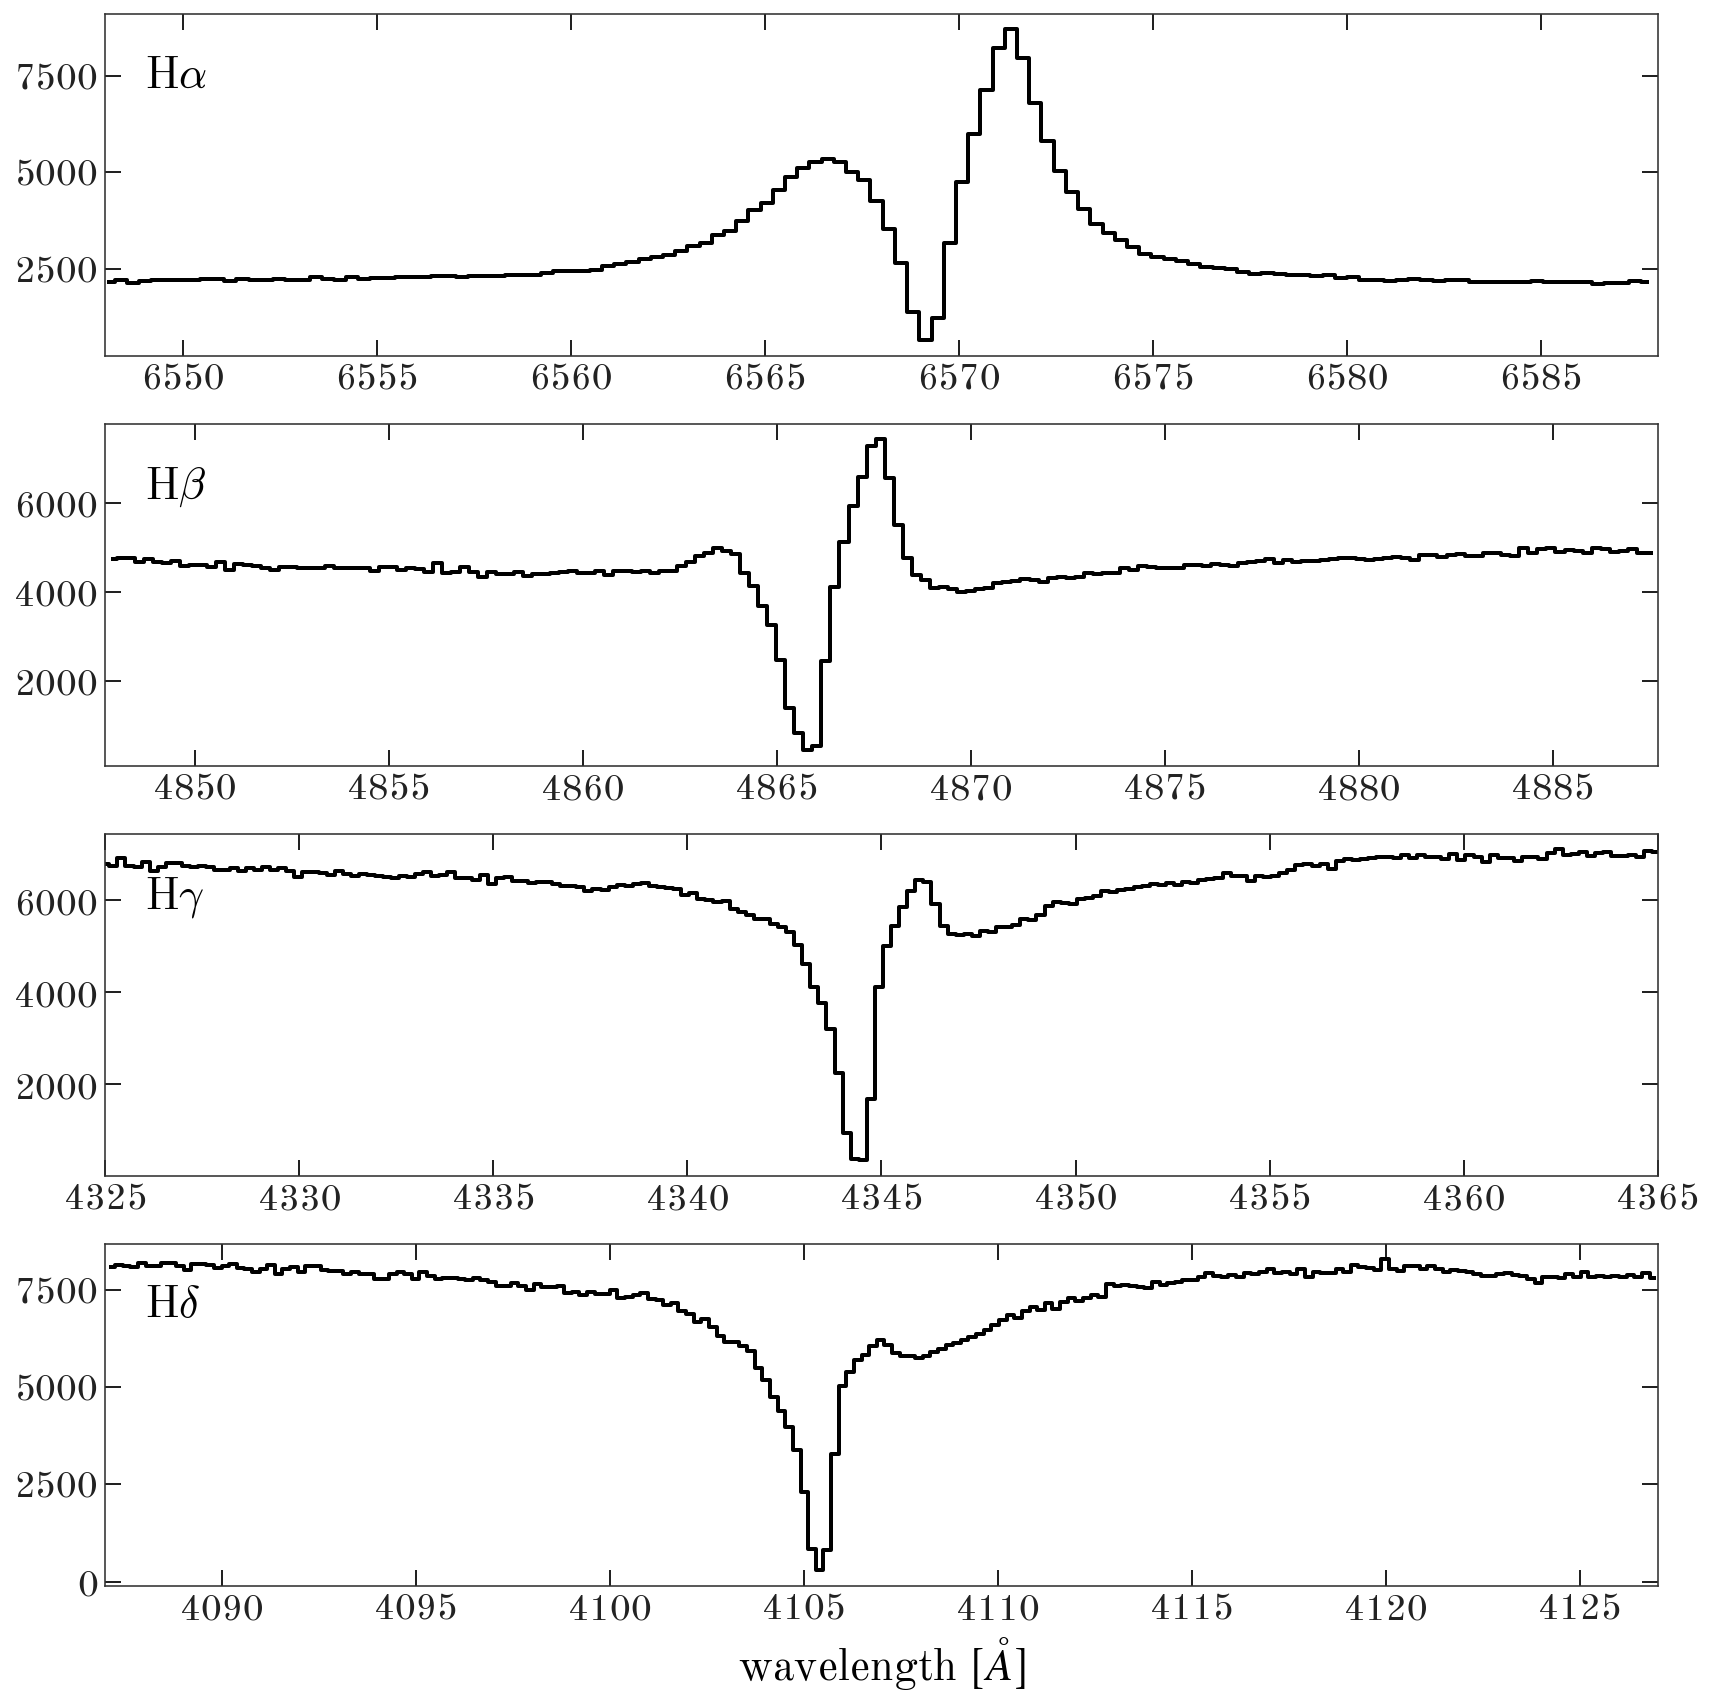

In [44]:
# wvln_lim = (4000, 8000)
pad = 20. # angstroms
vshift = 5.
wvln_lims = [6563 + np.array([-pad, pad]) + vshift,
             4862.7 + np.array([-pad, pad]) + vshift,
             4340 + np.array([-pad, pad]) + vshift,
             4102 + np.array([-pad, pad]) + vshift]
    
fig, axes = plt.subplots(len(wvln_lims), 1, figsize=(12, 3 * len(wvln_lims)))

chars = [r'H$\alpha$',
         r'H$\beta$',
         r'H$\gamma$',
         r'H$\delta$']
for i, wvln_lim in enumerate(wvln_lims):
    ax = axes[i]
    mask = (spec.wavelength > wvln_lim[0]*u.angstrom) & (spec.wavelength < wvln_lim[1]*u.angstrom)

    x = spec.wavelength[mask]
    y = spec.flux[mask]

    ax.plot(x, y, marker='', drawstyle='steps-mid', lw=2, color='k')
    ax.set_xlim(wvln_lim)
    
    ylim = ax.get_ylim()
    ax.text(wvln_lim[0] + 1., ylim[1] - 0.12*(ylim[1]-ylim[0]), chars[i], 
            va='top', fontsize=22)

# for l in balmer:
#     ax.axvline(l)

ax.set_xlabel(r'wavelength [$\AA$]')

fig.tight_layout()

### CMD / sky / proper motion:

In [17]:
pt_thresh = 8

lite_ptstyle = dict(marker='.', ls='none', alpha=0.2, color='k')

dark_ptstyle = dict(marker='.', ls='none', ms=6,
                    alpha=0.6, color='k')

In [205]:
all_g = GaiaData('../data/data-joined.fits')
all_c = all_g.get_skycoord(distance=False)

# near_cluster = (all_c.separation(cluster_c) < 3*u.deg) & (all_g.G0 < 20)
near_cluster = (all_g.G0 < 20)
g = all_g[near_cluster]
c = all_c[near_cluster]

mag_c = c.transform_to(gc.MagellanicStream)

In [206]:
def make_panel(ax, col, mag, col_lim, mag_lim,
               col_label, mag_label, poly_mask, flipy=True):
    col_binsize = 0.04
    mag_binsize = 0.10
    # norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=5e1)
    norm = mpl.colors.LogNorm(vmin=1e-1, vmax=1e4)

    H, xe, ye = np.histogram2d(col, mag,
                               bins=(np.arange(col_lim[0], col_lim[1]+1e-3, col_binsize),
                                     np.arange(mag_lim[0], mag_lim[1]+1e-3, mag_binsize)))

    # H[H < pt_thresh] = np.nan
    m = ax.pcolormesh(xe, ye, H.T, 
                      norm=norm, label='', 
                      cmap='Greys',  zorder=-1000,
                      rasterized=True, linewidth=0)
    
    if poly_mask is not None:
        ax.plot(col[poly_mask], mag[poly_mask], 
                zorder=100, label='', **dark_ptstyle)
    ax.set_xlim(col_lim)
    
    if flipy:
        ax.set_ylim(mag_lim[::-1])
    else:
        ax.set_ylim(mag_lim)
    
    ax.set_xlabel(col_label)
    ax.set_ylabel(mag_label)

In [207]:
cluster_pm = [-0.56, 0.47] * u.mas/u.yr

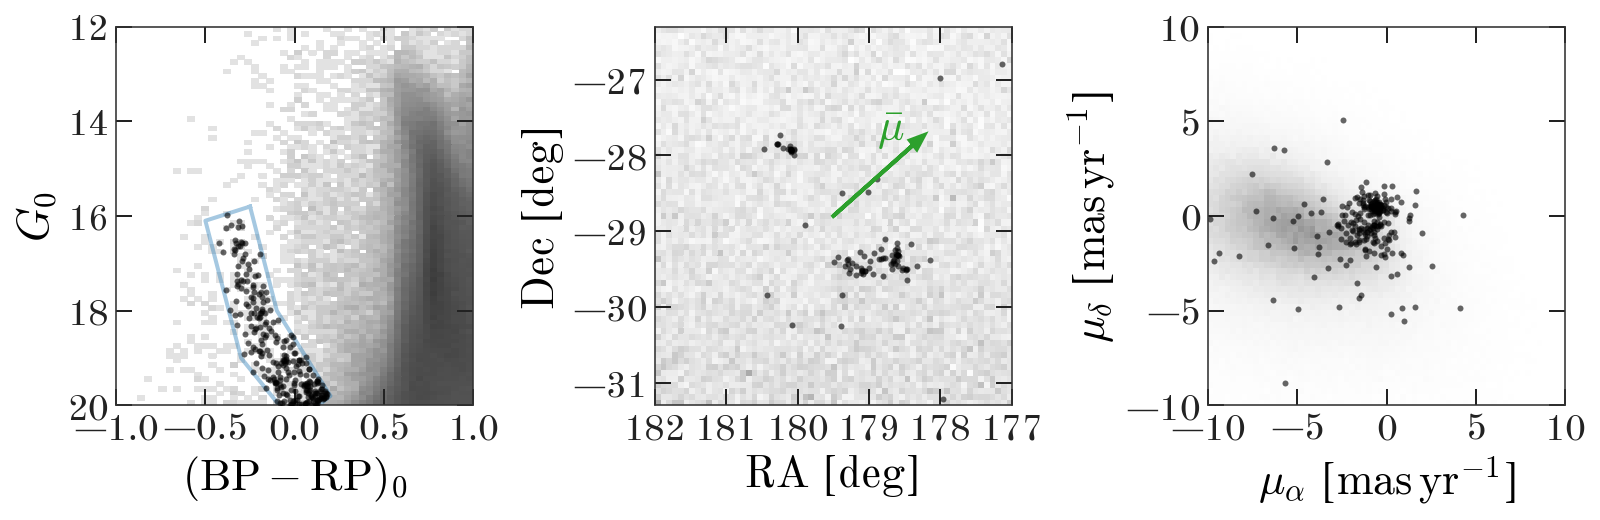

In [208]:
nodes = np.array([[-0.25, 15.8],
                  [-0.1, 18.],
                  [0.2, 19.8],
                  [0.0, 20.4],
                  [-0.3, 19.],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
polygon = mpl.path.Path(nodes)
mask = polygon.contains_points(np.vstack((g.BP0-g.RP0, g.G0)).T)

fig, axes = plt.subplots(1, 3, figsize=(11, 3.5), 
                         constrained_layout=True)

make_panel(axes[0],
           col=g.BP0-g.RP0,
           mag=g.G0,
           col_lim=(-1, 1),
           mag_lim=(12, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$',
           poly_mask=mask)

axes[0].plot(nodes[:, 0], nodes[:, 1], 
             marker='', color='tab:blue', lw=2, alpha=0.4)
axes[0].set_ylim(20, 12)

style = dict(marker='', linewidth=3, ls='-',
             alpha=0.5, color='tab:red', zorder=-100)

# ------
# Sky plot

ax = axes[1]

ax.set_xlim(cluster_c.ra.degree + 2.5,
            cluster_c.ra.degree - 2.5)
ax.set_ylim(cluster_c.dec.degree - 2.5,
            cluster_c.dec.degree + 2.5)

H, xe, ye = np.histogram2d(all_g.ra, all_g.dec, 
                           bins=(np.linspace(*ax.get_xlim()[::-1], num=64),
                                 np.linspace(*ax.get_ylim(), num=64)))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmax=2 * H.max())
# pm_mask = np.sqrt((g.pmra.value - -0.5)**2 + (g.pmdec.value - 0.5)**2) < 1.5
pm_mask = (g.pm_prob > 0.2)
ax.plot(g.ra[mask & pm_mask], 
        g.dec[mask & pm_mask], 
        **dark_ptstyle)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

dx, dy = cluster_pm * 2
ax.arrow(cluster_c.ra.degree,
         cluster_c.dec.degree,
         dx.value, dy.value, 
         head_width=0.15, head_length=0.2,
         linewidth=2, color='tab:green', zorder=1000)

ax.text(178.5, -27.8, r'$\bar{\mu}$', ha='right',
        fontsize=22, color='tab:green')

# ------
# PM plot

ax = axes[2]

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

H, xe, ye = np.histogram2d(all_g.pmra, all_g.pmdec, 
                           bins=(np.linspace(*ax.get_xlim(), num=64),
                                 np.linspace(*ax.get_ylim(), num=64)))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmax=2 * H.max())
ax.plot(g.pmra[mask], 
        g.pmdec[mask], 
        **dark_ptstyle)

ax.set_xlabel(r'$\mu_\alpha$ [{:latex_inline}]'.format(u.mas/u.yr))    
ax.set_ylabel(r'$\mu_\delta$ [{:latex_inline}]'.format(u.mas/u.yr))

axes[0].xaxis.set_ticks(np.arange(-1, 1+1e-3, 0.5))
axes[1].xaxis.set_ticks(np.arange(177, 182+1e-3, 1))
axes[2].xaxis.set_ticks(np.arange(-10, 10+1e-3, 5))

fig.savefig('../plots/talks/threepanel_5.png', dpi=250)

### Three-panel with MIKE targets

In [209]:
from astropy.table import hstack

In [210]:
mike = Table.read('../data/mike_final.fits')[6:]
mike_c = coord.SkyCoord(mike['RA'], mike['DEC'], unit=u.deg)

In [211]:
idx, sep, _ = coord.match_coordinates_sky(mike_c, all_c)

In [212]:
joined = hstack((mike[sep < 12*u.arcsec], 
                 all_g.data[idx[sep < 12*u.arcsec]]))
len(joined)

28

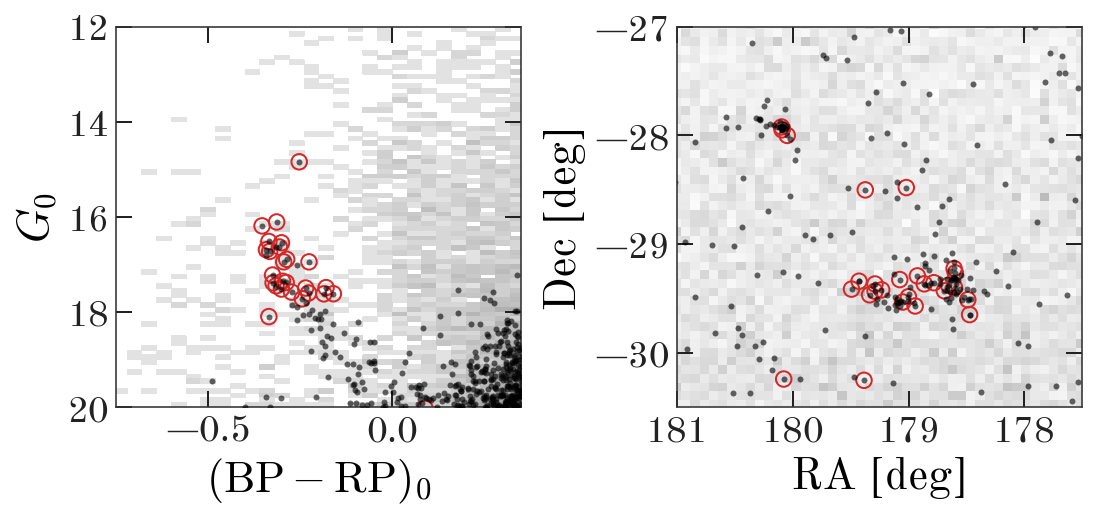

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5), 
                         constrained_layout=True)

make_panel(axes[0],
           col=g.BP0-g.RP0,
           mag=g.G0,
           col_lim=(-1, 1),
           mag_lim=(12, 20.5),
           col_label=r'$({\rm BP}-{\rm RP})_0$',
           mag_label=r'$G_0$',
           poly_mask=g.pm_prob > 0.2)

style = dict(marker='', linewidth=3, ls='-',
             alpha=0.5, color='tab:red', zorder=-100)

# ------
# Sky plot

ax = axes[1]

ax.set_xlim(cluster_c.ra.degree + 2.5,
            cluster_c.ra.degree - 2.5)
ax.set_ylim(cluster_c.dec.degree - 2.5,
            cluster_c.dec.degree + 2.5)

H, xe, ye = np.histogram2d(all_g.ra, all_g.dec, 
                           bins=(np.linspace(*ax.get_xlim()[::-1], num=64),
                                 np.linspace(*ax.get_ylim(), num=64)))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmax=2 * H.max())
ax.plot(all_g.ra[all_g.pm_prob > 0.2], 
        all_g.dec[all_g.pm_prob > 0.2], 
        **dark_ptstyle)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

axes[0].xaxis.set_ticks(np.arange(-1, 1+1e-3, 0.5))
axes[1].xaxis.set_ticks(np.arange(178, 181+1e-3, 1))

axes[1].scatter(joined['ra'], joined['dec'],
                marker='o', facecolor='none', s=60, color='tab:red')
axes[0].scatter(joined['BP0']-joined['RP0'], joined['G0'],
                marker='o', facecolor='none', s=60, color='tab:red')

axes[0].set_xlim(-0.75, 0.35)
axes[0].set_ylim(20, 12)

axes[1].set_xlim(181, 177.5)
axes[1].set_ylim(-30.5, -27)

fig.savefig('../plots/talks/twopanel_mike_2.png', dpi=250)

In [198]:
(1*u.deg * 29*u.kpc).to(u.pc, u.dimensionless_angles())

<Quantity 506.14548308 pc>

### Transparent thing

In [89]:
derp = Table()
derp['ra'] = g.ra[mask & pm_mask].value
derp['dec'] = g.dec[mask & pm_mask].value
derp.write('../plots/talks/pw1.fits')

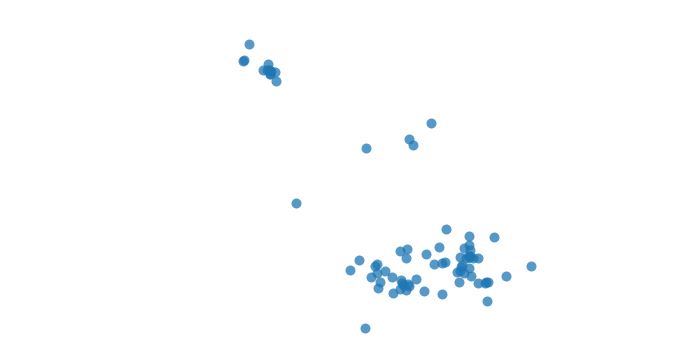

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(g.ra[mask & pm_mask], 
        g.dec[mask & pm_mask], 
        marker='o', ls='none', ms=5, alpha=0.75, mew=0,
        color='tab:blue')
ax.set_xlim(182, 177)
ax.set_ylim(-30, -27.5)
ax.set_aspect('equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for _, x in ax.spines.items():
    x.set_visible(False)
fig.savefig('../plots/talks/title.png', dpi=250)

### Tidal radius

In [40]:
Menc = gp.MilkyWayPotential().mass_enclosed([23, 0, 15.]*u.kpc)[0]
m = 1200 * u.Msun
(m / Menc)**(1/3) * np.linalg.norm([23, 0, 15.]) * 1000

<Quantity 45.15490951>

### MW disk in MC coordinates

In [41]:
disk_c = coord.SkyCoord(l=np.random.uniform(0, 360, 1000000)*u.deg,
               b=np.random.uniform(-10, 10, 1000000)*u.deg,
               frame='galactic').transform_to(gc.MagellanicStreamNidever08)

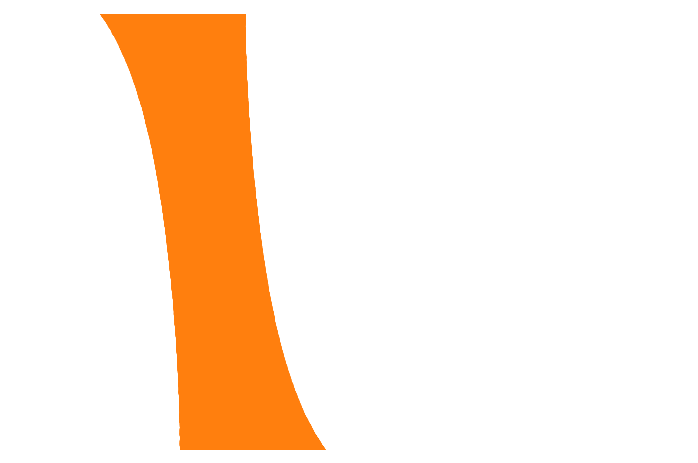

In [46]:
plt.plot(disk_c.L.degree, disk_c.B.degree, 
         marker='o', ls='none', color='tab:orange')
plt.xlim(80, -80)
plt.ylim(-50, 50)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
for _,x in plt.gca().spines.items():
    x.set_visible(False)

---

### RV / Fe/H distribution:

In [224]:
mike_data = Table.read('../data/mike_final.fits')
mike_data['pw1_id'] = [int(x.strip()[-2:]) if 'pw' in x else 9999 for x in mike_data['NAME']]

data = Table.read('../output/pw1-region-data-joined.fits')
data['pw1_id'] = [int(x.strip()[-2:]) if 'PW' in x else 9999 for x in data['pw1_name']]

In [231]:
all_tbl = join(data, mike_data, keys='pw1_id')
mike_tbl = all_tbl[all_tbl['pw1_name'] != '']
tbl = mike_tbl[(mike_tbl['SNR_RES'] > 10) & (mike_tbl['FEH'] < 0.)]
len(tbl)

21

In [232]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def robust_ln_prob(p, tbl):
    lnf, mu, lns = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    lp = lnf
    if not -10 < lnf < 0:
        return -np.inf
    lp += ln_normal(mu, -1, 4)
    
    l1 = ln_normal(tbl['FEH'], mu, s) + np.log(f)
    l2 = ln_normal(tbl['FEH'], 0, 5) + np.log(1-f)
    ll = np.logaddexp(l1, l2).sum()
    
    return ll + lp

In [234]:
np.sum(tbl['FEH']/tbl['FEHERR']**2) / np.sum(1/tbl['FEHERR']**2)

-1.1460298

In [235]:
np.sum(tbl['VHELIO']/tbl['VERR']**2) / np.sum(1/tbl['VERR']**2)

249.73225

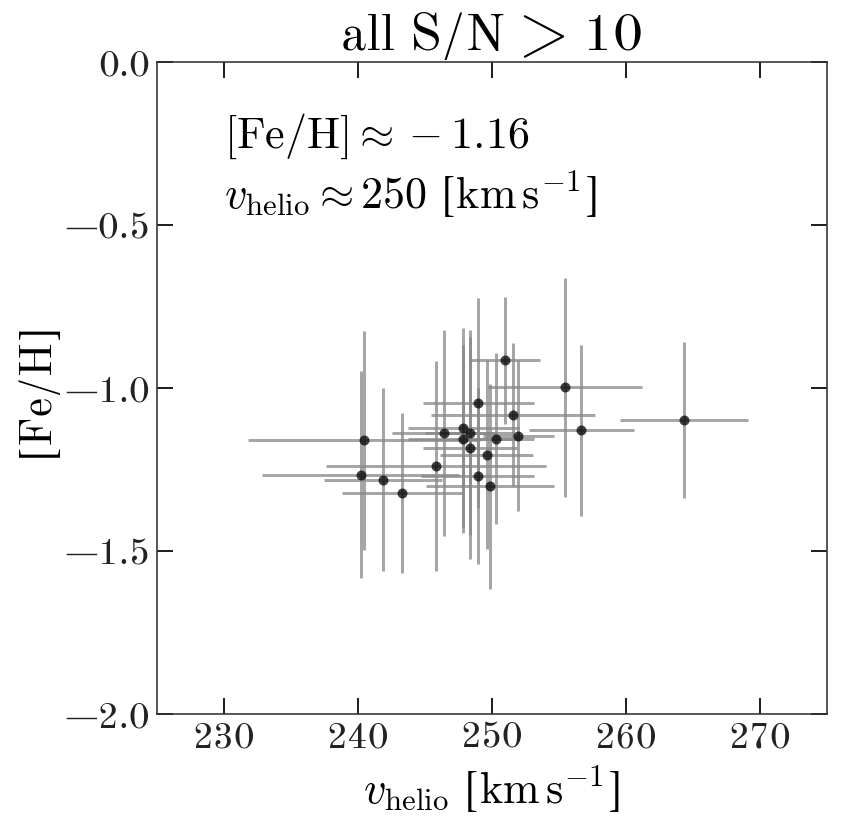

In [242]:
plt.figure(figsize=(6, 6))
plt.errorbar(tbl['VHELIO'], tbl['FEH'],
             xerr=tbl['VERR'], yerr=tbl['FEHERR'],
             ls='none', marker='o', ecolor='#888888', 
             alpha=0.75, color='k')

plt.xlim(225, 275)
plt.ylim(-2, 0)

ax = plt.gca()
ax.yaxis.set_ticks(np.arange(-2, 0+1e-3, 0.5))
ax.xaxis.set_ticks(np.arange(230, 270+1e-3, 10))

ax.text(230, -0.15, 
        (r'$[{\rm Fe}/{\rm H}] \approx -1.16$' + '\n' + 
         r'$v_{\rm helio} \approx 250$ ' + 
         '[{:latex_inline}]'.format(u.km/u.s)),
        ha='left', va='top', fontsize=22)

ax.set_ylabel(r'[Fe/H]')
ax.set_xlabel(r'$v_{\rm helio}$ ' + '[{:latex_inline}]'.format(u.km/u.s))

ax.set_title('all S/N > 10')

fig.tight_layout()

In [47]:
coord.SkyCoord(l=287.4560, b=22.9476, 
               unit=u.deg, frame='galactic').transform_to(gc.MagellanicStream)

<SkyCoord (MagellanicStreamNidever08): (L, B) in deg
    (54.74183826, -11.12909987)>